# Run 1-sided CNN with time-based windows

In [2]:
import tensorflow as tf
import numpy as np
import pickle
import os
import pandas as pd
import json
import datetime

import hashlib
import privacy_filter
import urllib
import requests
import time
import uuid
import itertools

import bigquery

#from google.cloud import stoa
from IPython.core.display import HTML, display, clear_output
from random import randint as randint

from dialoguer.dialoguer import offset_it, align_transcripts # Convert separate caller, callee side transcripts to dialogue
#from analyzer_time_window import EventAnalyzer as analyzer # Import the model (time-based windowing)
from FlaskApp.cnn.run_model import EventAnalyzer as analyzer

INFO:tensorflow:Restoring parameters from /Users/pranavbarot/Desktop/DataSci/CNN-models/FlaskApp/cnn/models/date/2018_02_05_1517843909/CNNv6_1sided_date_2018_02_05_1517843909-43000


In [2]:
import sys
bigquery.__path__

['/Users/pranavbarot/anaconda/envs/py27/lib/python2.7/site-packages/bigquery']

In [3]:
sys.path.insert(0, '/Users/pranavbarot/anaconda/lib/python3.6/site-packages/google/cloud/bigquery')

In [4]:
sys.path.insert(0, '/Users/pranavbarot/anaconda/lib/python3.6/site-packages/google/cloud/storage')


In [5]:
sys.path.insert(0, '/Users/pranavbarot/anaconda/lib/python3.6/site-packages/google/cloud')

In [6]:
sys.path.insert(0, '/Users/pranavbarot/anaconda/lib/python3.6/site-packages/google/cloud/storage/')

In [7]:
sys.path.insert(0, '/Users/pranavbarot/anaconda/envs/py27/lib/python2.7/site-packages/google_cloud_storage-1.6.0-py3.6-nspkg.pth')


TypeError: unbound method run_text() must be called with EventAnalyzer instance as first argument (got str instance instead)

In [8]:
import sys
stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout

## Get transcripts from BQ

In [9]:
# Get today's date
date = datetime.datetime.now().strftime('%Y-%m-%d')
print "Today's date: {}".format(date)

sales_orgs = ('Zenreach','TrendKite','Perfect Sense','peloton','selecthubprimary')
support_orgs = ('peetscs','ting','makespace','morehands','parkwhiz')

orgs = sales_orgs + support_orgs
transcripts_after = '2018-01-17'
transcripts_before = '2018-01-24'
max_transcripts = 10

Today's date: 2018-02-16


In [10]:
# mode = 'train'

## Download transcripts

In [125]:
bigquery_client = bigquery.client.('/opt/service-data.json')
#bigquery.client.from_service_account_json('/opt/service-data.json')

def query(query):
    query_job = bigquery_client.query(query)
    print 'Running SQL query: {}\n'.format(query)
    return query_job.result() # Wait for job to complete.

def result2dataframe(query_result):
    data = []
    for row in query_result:
        data.append(row.values())
    
    df = pd.DataFrame(data, columns=[col.name for col in query_result.schema])
    return df

In [126]:
# Changing this Query now because we will be getting labels for Test Set as well now.
def create_sql(org, transcripts_after, transcripts_before, max_transcripts_per_org):
    #standardSQL
    sql = """
    #standardSQL
    select * from `data_science.transcripts` a

    where a.call_id in (SELECT dial_id from `Sample_call_corpus.test_set`)

    """.format(org, transcripts_after, transcripts_before, max_transcripts_per_org*2)
    return sql

In [2]:
# Download transcripts from BQ and stratify over orgs:
transcripts_df = pd.DataFrame()
max_transcripts_per_org = max_transcripts/len(orgs)

for org in orgs:
    print "Collecting {0} transcripts for: {1}".format(max_transcripts_per_org,org)
    
    sql = create_sql(org, transcripts_after,transcripts_before, max_transcripts_per_org)
    result = query(sql)
    df_t = result2dataframe(result)
    print "Number of rows collected: {}".format(len(df_t))
    if not len(df_t) == 0:
        # Put into dataframe
        transcripts_df = pd.concat([transcripts_df, df_t], axis=0)
    else:
        print "No transcripts found for: {}".format(org)

NameError: name 'max_transcripts' is not defined

In [304]:
transcripts_df = pd.read_json('/Users/pranavbarot/Downloads/Pranav%2Fdev_set_results.json', lines = True, convert_dates=True)

In [305]:
# Clean
transcripts_df.drop_duplicates(subset=['call_id', 'call_side'], inplace=True)

In [306]:
transcripts_df.head(2)

,call_id,call_side,created,duration,from,full_name,link,organization_id,organization_name,rep_name,source,taste,to,updated,user_id
0,0001e4e4-f332-1235-06b0-0cc47a392728,caller,2017-08-03 21:03:13 UTC,149.079997,+18087572210,Kelcey_Harris,0,00Di0000000JDnoEAG,Zenreach,Kelcey Harris,asp,"[{u'duration': 0.44, u'raw': u'[noise]', u'sti...",14804823071,2017-08-03 21:07:33.481872 UTC,005i0000008YXhqAAG
2,0001e4e4-f332-1235-06b0-0cc47a392728,callee,2017-08-03 21:03:20 UTC,149.079997,+18087572210,Kelcey_Harris,0,00Di0000000JDnoEAG,Zenreach,Kelcey Harris,asp,"[{u'duration': 0.06, u'raw': u'[noise]', u'sti...",18087572210,2017-08-03 21:08:05.67969 UTC,005i0000008YXhqAAG


In [307]:
# Print some stats
print transcripts_df['call_side'].value_counts()
print min(transcripts_df['created'])
print max(transcripts_df['created'])
print transcripts_df['organization_name'].value_counts()
# save transcripts to pickle (recommended if big download)
#transcripts_df.to_pickle('temp_transcripts_{}.pickle'.format(date))

callee     887
caller     887
manager      4
Name: call_side, dtype: int64
2017-03-10 15:33:31 UTC
2017-09-18 21:22:59 UTC
Zenreach    1778
Name: organization_name, dtype: int64


In [308]:
#date='2018-01-04'

In [309]:
#transcripts_df = pd.read_pickle('temp_transcripts_{}.pickle'.format(date))
#transcripts_df = pd.read_pickle('temp_transcripts.pickle')

In [310]:
# Clean transcripts df
print len(transcripts_df)
transcripts_df = transcripts_df[transcripts_df['call_side']!='manager']
transcripts_df.drop_duplicates(subset=['call_id', 'call_side'], inplace=True)
print len(transcripts_df)

1778
1774


In [311]:
from dateutil import parser
new_date = []
for uni in transcripts_df['created']:
    x = parser.parse(uni)
    new_date.append(x)

In [312]:
transcripts_df['created'] = new_date

In [313]:
# Dialogue transcripts
count = 0
dialogued_transcripts = []
missed = 0
drop = []
grouped = transcripts_df.groupby('call_id')

for call_id, group in grouped:
    if sorted(group['call_side'].tolist()) == ['callee', 'caller']:
        count+=1 
        transcripts = group.to_dict(orient='records')
        offset, side_order = offset_it(transcripts)
        dialogued_transcripts.append(align_transcripts(transcripts, side_order, offset))
        
    else:
        drop.append(call_id) 
        continue
    if count % 1000 == 0: 
        print "{} of {} transcripts processed".format(count, len(transcripts_df))
        print "{} transcripts dropped".format(len(drop))
        

print "Finished with {} transcripts missed.".format(missed)

Finished with 0 transcripts missed.


In [314]:
# Put in dataframe 
dialogued_transcripts_df = pd.DataFrame.from_records(dialogued_transcripts)
print "No of dialogued transcripts: {}".format(len(dialogued_transcripts_df))

No of dialogued transcripts: 887


In [315]:
dialogued_transcripts_df.to_json('temp_dialogued_transcripts.json', orient='records', lines=True)

In [316]:
# The dialogued taste looks something like this:
# [...,
#  {u'conf': 1.0,
#   u'duration': 0.78,
#   u'etime': 12.78,
#   'index': 10,
#   u'raw': u'yes',
#   'spk': 0,
#   u'stime': 12.0},
#  {u'conf': 1.0,
#   u'duration': 0.21,
#   u'etime': 14.6,
#   'index': 0,
#   u'raw': u'your',
#   'spk': 1,
#   u'stime': 14.39},
# ...]

In [317]:
# Specify the location of the saved model parameters

with open(os.path.join("models","date","2018_02_16_1518795507","parameters.json")) as f:
    parameters = json.load(f)

parameters['window_duration'] = 20 #secs
parameters['window_slide'] = 15 #secs
parameters['classification_threshold'] = 0.3


print "moment: {}".format(parameters['moment'])
print "model_version: {}".format(parameters['model_version'])
print "moment_side: {}".format(parameters['moment_side'])
print "classification_threshold: {}".format(parameters['classification_threshold'])
print "window_duration: {}".format(parameters['window_duration'])
print "window_slide: {}".format(parameters['window_slide']   ) 

moment: date
model_version: CNNv6_1sided_date_2018_02_16_1518795507-24500
moment_side: caller
classification_threshold: 0.3
window_duration: 20
window_slide: 15


In [303]:
sample_df.to_csv('~/Downloads/dev_set.csv', index= False)

In [291]:
sample_df.drop("taste", axis = 1, inplace = True)
sample_df.drop("Text Window", axis = 1, inplace = True)

In [301]:
sample_df.drop(["Cleaned Text"], axis= 1, inplace = True)

In [318]:
sample_df

,Label,Unnamed: 0.1.1,abs_time,created,duration,event_value,organization_name,position,position_list,time,text,label value,call_id,dataset,confidence
0,True,0,2017-08-03 21:05:14.670000+00:00,2017-08-03 21:03:13 UTC,149.079997,thursday,Zenreach,"(177, 178)",NaN,121.67,so you may try giving you a call uh next thurs...,1,0001e4e4-f332-1235-06b0-0cc47a392728,dev,0.09
1,False,0,2017-08-03 21:05:12.630000+00:00,2017-08-03 21:03:13 UTC,149.079997,may,Zenreach,"(169, 170)","[169, 170]",119.63,are probably a little hectic at the location s...,0,0001e4e4-f332-1235-06b0-0cc47a392728,dev,0.03
7,True,2,2017-08-18 14:27:18.230000+00:00,2017-08-18 14:26:04 UTC,77.752894,friday,Zenreach,"(131, 132)",NaN,74.23,i'll try that i appreciate it hi thanks i'm gr...,1,0014f782-fec4-1235-06b0-0cc47a392728,dev,0.02
325,True,19,2017-06-16 17:14:26.910000+00:00,2017-06-16 16:59:34 UTC,931.747281,monday,Zenreach,"(1395, 1396)",NaN,892.91,you out a switch um which you probably get on ...,1,00c950ea-cd58-1235-06b0-0cc47a392728,dev,0.84
326,False,432,2017-06-16 17:00:00.610000+00:00,2017-06-16 16:59:34 UTC,931.747281,second,Zenreach,"(13, 14)","[13, 14]",26.61,[noise] [noise] hold on thank you though [nois...,0,00c950ea-cd58-1235-06b0-0cc47a392728,dev,0.11
327,False,433,2017-06-16 17:00:03.020000+00:00,2017-06-16 16:59:34 UTC,931.747281,second,Zenreach,"(18, 19)","[18, 19]",29.02,you though [noise] [noise] [noise] second fine...,0,00c950ea-cd58-1235-06b0-0cc47a392728,dev,0.00
328,False,434,2017-06-16 17:07:38.940000+00:00,2017-06-16 16:59:34 UTC,931.747281,second,Zenreach,"(873, 874)","[873, 874]",484.94,[noise] [noise] yeah that's a problem probably...,0,00c950ea-cd58-1235-06b0-0cc47a392728,dev,0.00
329,False,435,2017-06-16 17:07:54.780000+00:00,2017-06-16 16:59:34 UTC,931.747281,second,Zenreach,"(932, 933)","[932, 933]",500.78,that would be okay um so i can my one second o...,0,00c950ea-cd58-1235-06b0-0cc47a392728,dev,0.00
330,False,436,2017-06-16 17:11:29.270000+00:00,2017-06-16 16:59:34 UTC,931.747281,monday,Zenreach,"(1207, 1208)","[1207, 1208]",715.27,get get that sent out you and then maybe on mo...,0,00c950ea-cd58-1235-06b0-0cc47a392728,dev,0.00
331,False,437,2017-06-16 17:11:44.970000+00:00,2017-06-16 16:59:34 UTC,931.747281,second,Zenreach,"(1251, 1252)","[1251, 1252]",730.97,that's not a problem um so give me one more se...,0,00c950ea-cd58-1235-06b0-0cc47a392728,dev,0.19


In [319]:
import pandas as pd
mylist = []

for chunk in  pd.read_csv('/Users/pranavbarot/Desktop/DataSci/date_tp_fp_full.csv', chunksize=400, encoding = 'utf8'):
    mylist.append(chunk)

joined_df = pd.concat(mylist, axis= 0)
del mylist

In [320]:
# Create model object
model = analyzer(os.path.join(parameters['model_dir']), params=parameters)

INFO:tensorflow:Restoring parameters from models/date/2018_02_16_1518795507/CNNv6_1sided_date_2018_02_16_1518795507-24500


In [22]:
# Run model over dialogued transcripts
transcript_count = 0
events_list = []
max_events = 100000

for idx, transcript in dialogued_transcripts_df.iterrows():
    events = model.run_taste(transcript)
    if events:
        events_list.extend(events)
        print "EVENT"

        if len(events_list) >= max_events:
            print "max events count reached."
            break
    
    if transcript_count % 20 == 0:
        clear_output()
        print "{} events in {} transcripts found".format(len(events_list), transcript_count)

    transcript_count+=1

AttributeError: 'EventAnalyzer' object has no attribute 'run_taste'

In [736]:
model.run_text("run it um so if we get plugged in on thursday you'll have you'll we live for thirty five days or")

{'event_name': u'date',
 'model_name': 'CNN',
 'model_version': u'CNNv6_1sided_date_2018_02_16_1518795507-24500',
 'probability': 0.09,
 'words': [u'run',
  u'it',
  u'so',
  u'if',
  u'we',
  u'get',
  u'plugged',
  u'in',
  u'on',
  u'thursday',
  u"you'll",
  u'have',
  u"you'll",
  u'we',
  u'live',
  u'for',
  u'thirty',
  u'five',
  u'days',
  u'or',
  u'<PAD>'],
 'y_pred': 0}

In [19]:
from collections import Counter
Counter(joined_df['label value'])

Counter({0: 83232, 1: 7556})

In [241]:
joined = joined_df[['dial_id', 'text', 'label value']]
calls = pd.read_json('/Users/pranavbarot/Downloads/Pranav%2Fmatches.json', lines = True, encoding = 'utf8')
sample_df = joined_df.merge(calls, how = 'inner', left_on='dial_id', right_on='call_id')

In [564]:
sample_df = sample_df[sample_df['dataset'] == 'dev']
len(confidences)

8347

In [245]:
confidences = []

count = 0

for idx, row in sample_df.iterrows():
    count = count +1
    if count%100 == 0:
        print count
    words = row['text']
    data = model.run_text(str(words))
    confidences.append(data['probability'])

sample_df['confidence'] = confidences

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300


In [258]:
sample_df['confidence'] = confidences[0:6500]
sample_df = sample_df[sample_df['event_type'] == 'date']

In [565]:
sample_df.to_csv("~/Downloads/dev_set_evaluation.csv", index = False)

## Plotting the CNN confidences, compare by label value

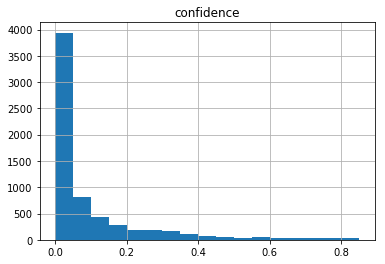

In [570]:
import matplotlib.pyplot as plt
sample_df.hist('confidence', bins = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85])
plt.show()

In [260]:
Counter(sample_df['label value'])

Counter({0: 5776, 1: 724})

In [261]:
col = sample_df['label value'].map({1:'r', 0:'b'})

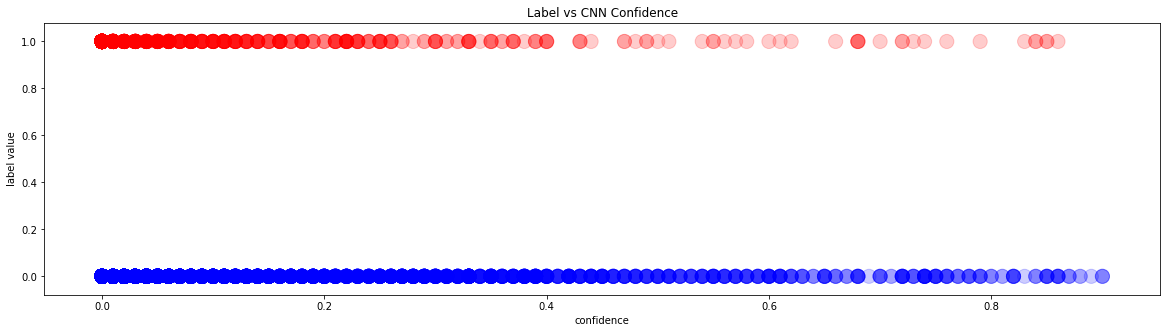

In [262]:
sample_df.plot.scatter(x = 'confidence', y='label value', c=col, title = 'Label vs CNN Confidence', alpha = 0.2, s = 200, figsize = (20,5))
plt.show()

In [264]:
import sys
sys.path.insert(0, '/Users/pranavbarot/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py')
import matplotlib.pyplot as plt

In [265]:
#transcripts_df

In [321]:
durations = transcripts_df[['call_id','duration']]
#durations

In [267]:
# Put events in dataframe        
events_df = pd.DataFrame(events_list)

print "No of events: {}".format(len(events_df))
#print "Hit rate: {}".format(len(events_list)/float(transcript_count))

# Display a random sample
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', 100)
#events_df

NameError: name 'events_list' is not defined

In [268]:
sample_df

,Unnamed: 0,Cleaned Text,Label,Text Window,Unnamed: 0.1,Unnamed: 0.1.1,abs_time,call_side,call_side.1,created,...,position,position_list,raw_words,taste,time,text,label value,call_id,dataset,confidence
0,0,"['so', 'you', 'may', 'try', 'giving', 'you', '...",True,"[""'so',"", ""'you',"", ""'may',"", ""'try',"", ""'givi...",0,0,2017-08-03 21:05:14.670000+00:00,caller,caller,2017-08-03 21:03:13 UTC,...,"(177, 178)",NaN,"['[noise]', '[noise]', '[noise]', '[noise]', '...","[{u'duration': 0.44, u'raw': u'[noise]', u'sti...",121.67,so you may try giving you a call uh next thurs...,1,0001e4e4-f332-1235-06b0-0cc47a392728,dev,0.09
1,7556,"['are', 'probably', 'a', 'little', 'hectic', '...",False,"[""'are',"", ""'probably',"", ""'a',"", ""'little',"",...",0,0,2017-08-03 21:05:12.630000+00:00,caller,caller,2017-08-03 21:03:13 UTC,...,"(169, 170)","[169, 170]","['[noise]', '[noise]', '[noise]', '[noise]', '...","[{u'duration': 0.44, u'raw': u'[noise]', u'sti...",119.63,are probably a little hectic at the location s...,0,0001e4e4-f332-1235-06b0-0cc47a392728,dev,0.03
7,2,"[""i'll"", 'try', 'that', 'i', 'appreciate', 'it...",True,"['""i\'ll"",', ""'try',"", ""'that',"", ""'i',"", ""'ap...",2,2,2017-08-18 14:27:18.230000+00:00,caller,caller,2017-08-18 14:26:04 UTC,...,"(131, 132)",NaN,"['[noise]', '[noise]', '[noise]', '[noise]', '...","[{u'duration': 0.02, u'raw': u'[noise]', u'sti...",74.23,i'll try that i appreciate it hi thanks i'm gr...,1,0014f782-fec4-1235-06b0-0cc47a392728,dev,0.02
325,19,"['you', 'out', 'a', 'switch', 'um', 'which', '...",True,"[""'you',"", ""'out',"", ""'a',"", ""'switch',"", ""'um...",19,19,2017-06-16 17:14:26.910000+00:00,caller,caller,2017-06-16 16:59:34 UTC,...,"(1395, 1396)",NaN,"['[noise]', '[noise]', '[noise]', '[noise]', '...","[{u'duration': 1.44, u'raw': u'[noise]', u'sti...",892.91,you out a switch um which you probably get on ...,1,00c950ea-cd58-1235-06b0-0cc47a392728,dev,0.84
326,7886,"['[noise]', '[noise]', 'hold', 'on', 'thank', ...",False,"[""'[noise]',"", ""'[noise]',"", ""'hold',"", ""'on',...",330,432,2017-06-16 17:00:00.610000+00:00,caller,caller,2017-06-16 16:59:34 UTC,...,"(13, 14)","[13, 14]","['[noise]', '[noise]', '[noise]', '[noise]', '...","[{u'duration': 1.44, u'raw': u'[noise]', u'sti...",26.61,[noise] [noise] hold on thank you though [nois...,0,00c950ea-cd58-1235-06b0-0cc47a392728,dev,0.11
327,7887,"['you', 'though', '[noise]', '[noise]', '[nois...",False,"[""'you',"", ""'though',"", ""'[noise]',"", ""'[noise...",331,433,2017-06-16 17:00:03.020000+00:00,caller,caller,2017-06-16 16:59:34 UTC,...,"(18, 19)","[18, 19]","['[noise]', '[noise]', '[noise]', '[noise]', '...","[{u'duration': 1.44, u'raw': u'[noise]', u'sti...",29.02,you though [noise] [noise] [noise] second fine...,0,00c950ea-cd58-1235-06b0-0cc47a392728,dev,0.00
328,7888,"['[noise]', '[noise]', 'yeah', ""that's"", 'a', ...",False,"[""'[noise]',"", ""'[noise]',"", ""'yeah',"", '""that...",332,434,2017-06-16 17:07:38.940000+00:00,caller,caller,2017-06-16 16:59:34 UTC,...,"(873, 874)","[873, 874]","['[noise]', '[noise]', '[noise]', '[noise]', '...","[{u'duration': 1.44, u'raw': u'[noise]', u'sti...",484.94,[noise] [noise] yeah that's a problem probably...,0,00c950ea-cd58-1235-06b0-0cc47a392728,dev,0.00
329,7889,"['that', 'would', 'be', 'okay', 'um', 'so', 'i...",False,"[""'that',"", ""'would',"", ""'be',"", ""'okay',"", ""'...",333,435,2017-06-16 17:07:54.780000+00:00,caller,caller,2017-06-16 16:59:34 UTC,...,"(932, 933)","[932, 933]","['[noise]', '[noise]', '[noise]', '[noise]', '...","[{u'duration': 1.44, u'raw': u'[noise]', u'sti...",500.78,that would be okay um so i can my one second o...,0,00c950ea-cd58-1235-06b0-0cc47a392728,dev,0.00
330,7890,"['get', 'get', 'that', 'sent', 'out', 'you', '...",False,"[""'get',"", ""'get',"", ""'that',"", ""'sent',"", ""'o...",334,436,2017-06-16 17:11:29.270000+00:00,caller,caller,2017-06-16 16:59:34 UTC,...,"(1207, 1208)","[1207, 1208]","['[noise]', '[noise]', '[noise]', '[noise]', '...","[{u'du

In [322]:
events_df = sample_df.merge(durations, how = 'inner', left_on = 'call_id', right_on='call_id')

In [325]:
events_df.drop_duplicates(subset = ['call_id','time'], inplace = True)
events_df

,Label,Unnamed: 0.1.1,abs_time,created,duration_x,event_value,organization_name,position,position_list,time,text,label value,call_id,dataset,confidence,duration_y
0,True,0,2017-08-03 21:05:14.670000+00:00,2017-08-03 21:03:13 UTC,149.079997,thursday,Zenreach,"(177, 178)",NaN,121.67,so you may try giving you a call uh next thurs...,1,0001e4e4-f332-1235-06b0-0cc47a392728,dev,0.09,149.079997
2,False,0,2017-08-03 21:05:12.630000+00:00,2017-08-03 21:03:13 UTC,149.079997,may,Zenreach,"(169, 170)","[169, 170]",119.63,are probably a little hectic at the location s...,0,0001e4e4-f332-1235-06b0-0cc47a392728,dev,0.03,149.079997
4,True,2,2017-08-18 14:27:18.230000+00:00,2017-08-18 14:26:04 UTC,77.752894,friday,Zenreach,"(131, 132)",NaN,74.23,i'll try that i appreciate it hi thanks i'm gr...,1,0014f782-fec4-1235-06b0-0cc47a392728,dev,0.02,77.752894
6,True,19,2017-06-16 17:14:26.910000+00:00,2017-06-16 16:59:34 UTC,931.747281,monday,Zenreach,"(1395, 1396)",NaN,892.91,you out a switch um which you probably get on ...,1,00c950ea-cd58-1235-06b0-0cc47a392728,dev,0.84,931.747281
8,False,432,2017-06-16 17:00:00.610000+00:00,2017-06-16 16:59:34 UTC,931.747281,second,Zenreach,"(13, 14)","[13, 14]",26.61,[noise] [noise] hold on thank you though [nois...,0,00c950ea-cd58-1235-06b0-0cc47a392728,dev,0.11,931.747281
10,False,433,2017-06-16 17:00:03.020000+00:00,2017-06-16 16:59:34 UTC,931.747281,second,Zenreach,"(18, 19)","[18, 19]",29.02,you though [noise] [noise] [noise] second fine...,0,00c950ea-cd58-1235-06b0-0cc47a392728,dev,0.00,931.747281
12,False,434,2017-06-16 17:07:38.940000+00:00,2017-06-16 16:59:34 UTC,931.747281,second,Zenreach,"(873, 874)","[873, 874]",484.94,[noise] [noise] yeah that's a problem probably...,0,00c950ea-cd58-1235-06b0-0cc47a392728,dev,0.00,931.747281
14,False,435,2017-06-16 17:07:54.780000+00:00,2017-06-16 16:59:34 UTC,931.747281,second,Zenreach,"(932, 933)","[932, 933]",500.78,that would be okay um so i can my one second o...,0,00c950ea-cd58-1235-06b0-0cc47a392728,dev,0.00,931.747281
16,False,436,2017-06-16 17:11:29.270000+00:00,2017-06-16 16:59:34 UTC,931.747281,monday,Zenreach,"(1207, 1208)","[1207, 1208]",715.27,get get that sent out you and then maybe on mo...,0,00c950ea-cd58-1235-06b0-0cc47a392728,dev,0.00,931.747281
18,False,437,2017-06-16 17:11:44.970000+00:00,2017-06-16 16:59:34 UTC,931.747281,second,Zenreach,"(1251, 1252)","[1251, 1252]",730.97,that's not a problem um so give me one more se...,0,00c950ea-cd58-1235-06b0-0cc47a392728,dev,0.19,931.747281


## Adding in fraction from start feature

In [326]:
fraction_start = []
fraction_end = []
for idx, row in (events_df.iterrows()):
    dur = row['duration_x']
    start = row['time']
    
    time_from_start = (float(start))/float(dur)
    fraction_start.append(time_from_start)


In [327]:
events_df['time from start'] = fraction_start

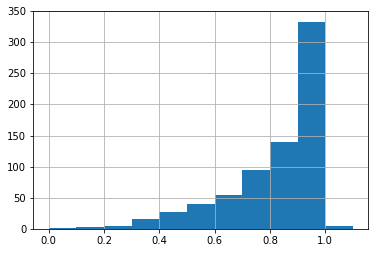

In [328]:
events_df[events_df['label value'] == 1]['time from start'].hist(bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1])
plt.show()

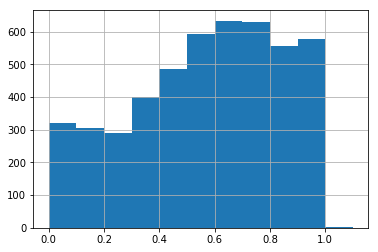

In [329]:
events_df[events_df['label value'] == 0]['time from start'].hist(bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1])
plt.show()

In [330]:
events_df['confidence'].max()
#events_df.loc[events_df['confidence'] > 0.8]

0.9

In [332]:
subset_df = events_df[['call_id', 'text','created', 'event_value']]
subset_df.dropna(inplace = True)

/Users/pranavbarot/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [334]:
import sys
sys.path.insert(0,'/Users/pranavbarot/Desktop/DataSci/normalize/normalize/constants.py')
sys.path.insert(0,'/Users/pranavbarot/Desktop/DataSci/normalize/normalize/')
sys.path.insert(0,'/Users/pranavbarot/anaconda/envs/py27/lib/python2.7/site-packages')

## Make some predictions with the earlier baseline model

In [613]:
from collections import OrderedDict
from constants import NO_MORE_DIGITS
from constants import NOT_AM_PM_RGX
from utils import Substituter
SUBSTITUTIONS = OrderedDict((

    # Convert to numbers
    ("one", "1"),
    ("two", "2"),
    ("three", "3"),
    ("four", "4"),
    ("five", "5"),
    ("six", "6"),
    ("seven", "7"),
    ("eight", "8"),
    ("nine", "9"),
    ("ten", "10"),
    ("eleven", "11"),
    ("twelve", "12"),
    ("second","2nd"),

    # If am/pm not present, assume morning/afternoon based on working day.
    ("8" + NOT_AM_PM_RGX, "8 am"),
    ("9" + NOT_AM_PM_RGX, "9 am"),
    ("10" + NOT_AM_PM_RGX, "10 am"),
    ("11" + NOT_AM_PM_RGX, "11 am"),
    ("12" + NOT_AM_PM_RGX, "12 pm"),
    ("1" + NO_MORE_DIGITS + NOT_AM_PM_RGX, "1 pm"),
    ("2" + NOT_AM_PM_RGX, "2 pm"),
    ("3" + NOT_AM_PM_RGX, "3 pm"),
    ("4" + NOT_AM_PM_RGX, "4 pm"),
    ("5" + NOT_AM_PM_RGX, "5 pm"),
    ("6" + NOT_AM_PM_RGX, "6 pm"),
    ("7" + NOT_AM_PM_RGX, "7 pm"),

    # Misc substitutions.
    ("o'clock", ""),

    # Collapse multiple suggested follow-up days to one (the latter).
    ("monday tuesday", "tuesday"),
    ("tuesday wednesday", "wednesday"),
    ("wednesday thursday", "thursday"),
    ("thursday friday", "friday"),
    ("friday saturday", "saturday"),
    ("saturday sunday", "sunday"),
    ("sunday monday", "monday"),
    
    # ordinals to days of month
    ("first", "1st"),
    ("second", "2nd"),
    ("third","3rd"),
    ("fourth","4th"),
    ("fifth","5th"),
    ("sixth","6th"),
    ("seventh","7th"),
    ("eighth","8th"),
    ("ninth","9th"),
    ("tenth","10th")
))

def _filter_adjacent_dups(s):
    """Filter adjacent duplicates from a string."""

    return " ".join([group[0] for group in groupby(s.split())])


def _normalize_text(text):
    """Prepare datetime text for parsing."""

    # Apply substitutions to snippet.
    substitute = Substituter(text)
    for pattern, repl in SUBSTITUTIONS.items():
        substitute(pattern, repl)

    # Remove adjacent duplicates (ex. monday monday).
    return substitute.get()

month_dict = {"1":"january",
              "2":"february",
              "3":"march",
              "4":"april",
              "5":"may",
              "6":"june",
              "7":"july",
              "8":"august",
              "9":"september",
              "10":"october",
              "11":"november",
              "12":"december"
             }



In [617]:
import dateparser
from dateutil import parser
import re
datewords = ['']

predictions = []
created_date = []
calls = []
utt = []
ev_val = []
ordinals = ["first","second","third","fourth","fifth","sixth","seventh","eighth","ninth","tenth"]
for idx, row in enumerate(subset_df.itertuples()):
    words = str(row[2])
    utt.append(words)
    calls.append(row[1])
    
    
    sub_pred = []
    created = row[3]
    created = parser.parse(created)
    created = created.replace(tzinfo=None)
    created_date.append(created)
    
    m = created.month
    m = month_dict.get(str(m))
    
    day = str(row[-1])
    clean = _normalize_text(day)
    if day in ordinals:
        prediction = dateparser.parse(m + clean, settings = {'PREFER_DATES_FROM': 'future','RELATIVE_BASE': created})

    else :
        prediction = dateparser.parse(clean, settings = {'PREFER_DATES_FROM': 'future','RELATIVE_BASE': created})
        
    sub_pred.append(prediction)
    predictions.append(sub_pred)
    ev_val.append(day)
            

In [618]:
predictions_df = pd.DataFrame(zip(calls, created_date, predictions, utt, ev_val))
predictions_df.rename(columns = {0:"call_id", 1:"created_at",2:"prediction", 3:"words", 4:"event value"}, inplace = True)

In [622]:
dateparser.parse("march 4th", settings={'PREFER_DAY_OF_MONTH': 'first'})

datetime.datetime(2018, 3, 4, 0, 0)

In [620]:
predictions_df

,call_id,created_at,prediction,words,event value
0,0001e4e4-f332-1235-06b0-0cc47a392728,2017-08-03 21:03:13,[2017-08-10 00:00:00],so you may try giving you a call uh next thursday around the same time [noise] [noise] okay awesome yeah that's,thursday
1,0001e4e4-f332-1235-06b0-0cc47a392728,2017-08-03 21:03:13,[2018-05-03 00:00:00],are probably a little hectic at the location so you may try giving you a call uh next thursday around the,may
2,0014f782-fec4-1235-06b0-0cc47a392728,2017-08-18 14:26:04,[2017-08-25 00:00:00],i'll try that i appreciate it hi thanks i'm great friday right [noise]',friday
3,00c950ea-cd58-1235-06b0-0cc47a392728,2017-06-16 16:59:34,[2017-06-19 00:00:00],you out a switch um which you probably get on monday and i'm still gonna send that out so then we,monday
4,00c950ea-cd58-1235-06b0-0cc47a392728,2017-06-16 16:59:34,[None],[noise] [noise] hold on thank you though [noise] [noise] [noise] second fine so for a second hey jillian it's jeremy figaro,second
5,00c950ea-cd58-1235-06b0-0cc47a392728,2017-06-16 16:59:34,[None],you though [noise] [noise] [noise] second fine so for a second hey jillian it's jeremy figaro uh with zenreach how are,second
6,00c950ea-cd58-1235-06b0-0cc47a392728,2017-06-16 16:59:34,[None],[noise] [noise] yeah that's a problem probably give me one second let me ask uh one of my colleagues a quick,second
7,00c950ea-cd58-1235-06b0-0cc47a392728,2017-06-16 16:59:34,[None],that would be okay um so i can my one second okay jillian all right [noise] [noise] okay [noise] jillian yeah,second
8,00c950ea-cd58-1235-06b0-0cc47a392728,2017-06-16 16:59:34,[2017-06-19 00:00:00],get get that sent out you and then maybe on monday we can go ahead and get you plugged in cause,monday
9,00c950ea-cd58-1235-06b0-0cc47a392728,2017-06-16 16:59:34,[None],that's not a problem um so give me one more second let me check something with one of my managers and,second


In [623]:
scoring_df = events_df.merge(predictions_df, how ='inner', left_on = 'text', right_on='words')
scoring_df

,Label,Unnamed: 0.1.1,abs_time,created,duration_x,event_value,organization_name,position,position_list,time,...,call_id_x,dataset,confidence,duration_y,time from start,call_id_y,created_at,prediction,words,event value
0,True,0,2017-08-03 21:05:14.670000+00:00,2017-08-03 21:03:13 UTC,149.079997,thursday,Zenreach,"(177, 178)",NaN,121.67,...,0001e4e4-f332-1235-06b0-0cc47a392728,dev,0.09,149.079997,0.816139,0001e4e4-f332-1235-06b0-0cc47a392728,2017-08-03 21:03:13,[2017-08-10 00:00:00],so you may try giving you a call uh next thursday around the same time [noise] [noise] okay awesome yeah that's,thursday
1,False,0,2017-08-03 21:05:12.630000+00:00,2017-08-03 21:03:13 UTC,149.079997,may,Zenreach,"(169, 170)","[169, 170]",119.63,...,0001e4e4-f332-1235-06b0-0cc47a392728,dev,0.03,149.079997,0.802455,0001e4e4-f332-1235-06b0-0cc47a392728,2017-08-03 21:03:13,[2018-05-03 00:00:00],are probably a little hectic at the location so you may try giving you a call uh next thursday around the,may
2,True,2,2017-08-18 14:27:18.230000+00:00,2017-08-18 14:26:04 UTC,77.752894,friday,Zenreach,"(131, 132)",NaN,74.23,...,0014f782-fec4-1235-06b0-0cc47a392728,dev,0.02,77.752894,0.954691,0014f782-fec4-1235-06b0-0cc47a392728,2017-08-18 14:26:04,[2017-08-25 00:00:00],i'll try that i appreciate it hi thanks i'm great friday right [noise]',friday
3,True,19,2017-06-16 17:14:26.910000+00:00,2017-06-16 16:59:34 UTC,931.747281,monday,Zenreach,"(1395, 1396)",NaN,892.91,...,00c950ea-cd58-1235-06b0-0cc47a392728,dev,0.84,931.747281,0.958318,00c950ea-cd58-1235-06b0-0cc47a392728,2017-06-16 16:59:34,[2017-06-19 00:00:00],you out a switch um which you probably get on monday and i'm still gonna send that out so then we,monday
4,False,432,2017-06-16 17:00:00.610000+00:00,2017-06-16 16:59:34 UTC,931.747281,second,Zenreach,"(13, 14)","[13, 14]",26.61,...,00c950ea-cd58-1235-06b0-0cc47a392728,dev,0.11,931.747281,0.028559,00c950ea-cd58-1235-06b0-0cc47a392728,2017-06-16 16:59:34,[None],[noise] [noise] hold on thank you though [noise] [noise] [noise] second fine so for a second hey jillian it's jeremy figaro,second
5,False,433,2017-06-16 17:00:03.020000+00:00,2017-06-16 16:59:34 UTC,931.747281,second,Zenreach,"(18, 19)","[18, 19]",29.02,...,00c950ea-cd58-1235-06b0-0cc47a392728,dev,0.00,931.747281,0.031146,00c950ea-cd58-1235-06b0-0cc47a392728,2017-06-16 16:59:34,[None],you though [noise] [noise] [noise] second fine so for a second hey jillian it's jeremy figaro uh with zenreach how are,second
6,False,434,2017-06-16 17:07:38.940000+00:00,2017-06-16 16:59:34 UTC,931.747281,second,Zenreach,"(873, 874)","[873, 874]",484.94,...,00c950ea-cd58-1235-06b0-0cc47a392728,dev,0.00,931.747281,0.520463,00c950ea-cd58-1235-06b0-0cc47a392728,2017-06-16 16:59:34,[None],[noise] [noise] yeah that's a problem probably give me one second let me ask uh one of my colleagues a quick,second
7,False,435,2017-06-16 17:07:54.780000+00:00,2017-06-16 16:59:34 UTC,931.747281,second,Zenreach,"(932, 933)","[932, 933]",500.78,...,00c950ea-cd58-1235-06b0-0cc47a392728,dev,0.00,931.747281,0.537463,00c950ea-cd58-1235-06b0-0cc47a392728,2017-06-16 16:59:34,[None],that would be okay um so i can my one second okay jillian all right [noise] [noise] okay [noise] jillian yeah,second
8,False,436,2017-06-16 17:11:29.270000+00:00,2017-06-16 16:59:34 UTC,931.747281,monday,Zenreach,"(1207, 1208)","[1207, 1208]",715.27,...,00c950ea-cd58-1235-06b0-0cc47a392728,dev,0.00,931.747281,0.767665,00c950ea-cd58-1235-06b0-0cc47a392728,2017-06-16 16:59:34,[2017-06-19 00:00:00],get get that sent out you and then maybe on monday we can go ahead and get you plugged in cause,monday
9,False,437,2017-06-16 17:11:44.970000+00:00,2017-06-16 16:59:34 UTC,931.747281,second,Zenreach,"(1251, 1252)","[1251, 1252]",730.97,...,00c950ea-cd58-1235-06b0-0cc47a392728,dev,0.19,931.747281,0.784515,00c950ea-cd58-1235-06b0-0cc47a392728,2017-06-16 16:59:34,[None],that's not a problem um so give me one more second let me check something with one of my managers and,second


In [624]:
scoring_df

,Label,Unnamed: 0.1.1,abs_time,created,duration_x,event_value,organization_name,position,position_list,time,...,call_id_x,dataset,confidence,duration_y,time from start,call_id_y,created_at,prediction,words,event value
0,True,0,2017-08-03 21:05:14.670000+00:00,2017-08-03 21:03:13 UTC,149.079997,thursday,Zenreach,"(177, 178)",NaN,121.67,...,0001e4e4-f332-1235-06b0-0cc47a392728,dev,0.09,149.079997,0.816139,0001e4e4-f332-1235-06b0-0cc47a392728,2017-08-03 21:03:13,[2017-08-10 00:00:00],so you may try giving you a call uh next thursday around the same time [noise] [noise] okay awesome yeah that's,thursday
1,False,0,2017-08-03 21:05:12.630000+00:00,2017-08-03 21:03:13 UTC,149.079997,may,Zenreach,"(169, 170)","[169, 170]",119.63,...,0001e4e4-f332-1235-06b0-0cc47a392728,dev,0.03,149.079997,0.802455,0001e4e4-f332-1235-06b0-0cc47a392728,2017-08-03 21:03:13,[2018-05-03 00:00:00],are probably a little hectic at the location so you may try giving you a call uh next thursday around the,may
2,True,2,2017-08-18 14:27:18.230000+00:00,2017-08-18 14:26:04 UTC,77.752894,friday,Zenreach,"(131, 132)",NaN,74.23,...,0014f782-fec4-1235-06b0-0cc47a392728,dev,0.02,77.752894,0.954691,0014f782-fec4-1235-06b0-0cc47a392728,2017-08-18 14:26:04,[2017-08-25 00:00:00],i'll try that i appreciate it hi thanks i'm great friday right [noise]',friday
3,True,19,2017-06-16 17:14:26.910000+00:00,2017-06-16 16:59:34 UTC,931.747281,monday,Zenreach,"(1395, 1396)",NaN,892.91,...,00c950ea-cd58-1235-06b0-0cc47a392728,dev,0.84,931.747281,0.958318,00c950ea-cd58-1235-06b0-0cc47a392728,2017-06-16 16:59:34,[2017-06-19 00:00:00],you out a switch um which you probably get on monday and i'm still gonna send that out so then we,monday
4,False,432,2017-06-16 17:00:00.610000+00:00,2017-06-16 16:59:34 UTC,931.747281,second,Zenreach,"(13, 14)","[13, 14]",26.61,...,00c950ea-cd58-1235-06b0-0cc47a392728,dev,0.11,931.747281,0.028559,00c950ea-cd58-1235-06b0-0cc47a392728,2017-06-16 16:59:34,[None],[noise] [noise] hold on thank you though [noise] [noise] [noise] second fine so for a second hey jillian it's jeremy figaro,second
5,False,433,2017-06-16 17:00:03.020000+00:00,2017-06-16 16:59:34 UTC,931.747281,second,Zenreach,"(18, 19)","[18, 19]",29.02,...,00c950ea-cd58-1235-06b0-0cc47a392728,dev,0.00,931.747281,0.031146,00c950ea-cd58-1235-06b0-0cc47a392728,2017-06-16 16:59:34,[None],you though [noise] [noise] [noise] second fine so for a second hey jillian it's jeremy figaro uh with zenreach how are,second
6,False,434,2017-06-16 17:07:38.940000+00:00,2017-06-16 16:59:34 UTC,931.747281,second,Zenreach,"(873, 874)","[873, 874]",484.94,...,00c950ea-cd58-1235-06b0-0cc47a392728,dev,0.00,931.747281,0.520463,00c950ea-cd58-1235-06b0-0cc47a392728,2017-06-16 16:59:34,[None],[noise] [noise] yeah that's a problem probably give me one second let me ask uh one of my colleagues a quick,second
7,False,435,2017-06-16 17:07:54.780000+00:00,2017-06-16 16:59:34 UTC,931.747281,second,Zenreach,"(932, 933)","[932, 933]",500.78,...,00c950ea-cd58-1235-06b0-0cc47a392728,dev,0.00,931.747281,0.537463,00c950ea-cd58-1235-06b0-0cc47a392728,2017-06-16 16:59:34,[None],that would be okay um so i can my one second okay jillian all right [noise] [noise] okay [noise] jillian yeah,second
8,False,436,2017-06-16 17:11:29.270000+00:00,2017-06-16 16:59:34 UTC,931.747281,monday,Zenreach,"(1207, 1208)","[1207, 1208]",715.27,...,00c950ea-cd58-1235-06b0-0cc47a392728,dev,0.00,931.747281,0.767665,00c950ea-cd58-1235-06b0-0cc47a392728,2017-06-16 16:59:34,[2017-06-19 00:00:00],get get that sent out you and then maybe on monday we can go ahead and get you plugged in cause,monday
9,False,437,2017-06-16 17:11:44.970000+00:00,2017-06-16 16:59:34 UTC,931.747281,second,Zenreach,"(1251, 1252)","[1251, 1252]",730.97,...,00c950ea-cd58-1235-06b0-0cc47a392728,dev,0.19,931.747281,0.784515,00c950ea-cd58-1235-06b0-0cc47a392728,2017-06-16 16:59:34,[None],that's not a problem um so give me one more second let me check something with one of my managers and,second


## Group predictions by call to analyze agreement

In [625]:
grouped = scoring_df.groupby('call_id_x')
ids = []
predictions = []


for idx, group in grouped:
    ids.append(group['call_id_x'].values[0])
    preds = []
    for i, thing in enumerate(group['prediction'].values):
        preds.extend(thing)
        predictions.append(preds)


In [626]:
len(predictions)

5427

In [627]:
agreement_df = pd.DataFrame(zip(ids, predictions), columns = ['dial_id', 'agreement'])

In [628]:
scoring_df = scoring_df.merge(agreement_df, how='inner', left_on='call_id_x', right_on='dial_id')

## Add in order_from_end feature

In [629]:
scoring_df = scoring_df.sort_values("dial_id")
scoring_df
count = 0

orders = pd.DataFrame()
for dial in set(scoring_df['dial_id']):
    df = scoring_df[scoring_df['dial_id'] == dial].reset_index(drop = True)
    df = df.sort_values("time from start")
    df['order'] = range(1,len(df)+1)[::-1]
    orders = pd.concat([orders, df], axis=0)

    count = count + 1
#     if count == 10:
#         break
    
    print (count)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [733]:
pd.set_option("display.max_colwidth", 50)

In [631]:
scoring_df = orders

## Heuristic scoring!

In [820]:
import math as m
scores= []
for idx, row in (scoring_df.iterrows()):
    conf = row['confidence']
    start_percent = row['time from start']
    #agr = row['agreement']
    order = row['order']
    scores.append(1/(float(order)) + (2*conf) + start_percent)
    

In [821]:
scoring_df['scores'] = scores
scoring_df

,Label,Unnamed: 0.1.1,abs_time,created,duration_x,event_value,organization_name,position,position_list,time,...,time from start,call_id_y,created_at,prediction,words,event value,dial_id,agreement,order,scores
0,True,6134,2017-05-17 17:34:14.140000+00:00,2017-05-17 17:33:41 UTC,98.236933,tuesday,Zenreach,"(70, 71)",NaN,33.14,...,0.217055,ce2fe3d9-b5c9-1235-06b0-0cc47a392728,2017-05-17 17:33:41,[2017-05-23 00:00:00],yes doing fantastic i tried to to reach you on...,tuesday,ce2fe3d9-b5c9-1235-06b0-0cc47a392728,"[2017-08-25 00:00:00, 2017-08-25 00:00:00, 201...",3,0.550388
1,False,91851,2017-05-17 17:34:16.690000+00:00,2017-05-17 17:33:41 UTC,98.236933,monday,Zenreach,"(83, 84)","[83, 84]",35.69,...,0.233757,ce2fe3d9-b5c9-1235-06b0-0cc47a392728,2017-05-17 17:33:41,[2017-05-22 00:00:00],told you are out of the office i i'm sorry mon...,monday,ce2fe3d9-b5c9-1235-06b0-0cc47a392728,"[2017-08-25 00:00:00, 2017-08-25 00:00:00, 201...",2,0.853757
2,False,91852,2017-05-17 17:35:02.920000+00:00,2017-05-17 17:33:41 UTC,98.236933,june,Zenreach,"(200, 201)","[200, 201]",81.92,...,0.536546,ce2fe3d9-b5c9-1235-06b0-0cc47a392728,2017-05-17 17:33:41,[2017-06-17 00:00:00],definitely reach out probably at the uh the be...,june,ce2fe3d9-b5c9-1235-06b0-0cc47a392728,"[2017-08-25 00:00:00, 2017-08-25 00:00:00, 201...",1,1.556546
1,False,113398,2017-08-09 18:33:25.200000+00:00,2017-08-09 18:32:55 UTC,400.782569,first,Zenreach,"(21, 22)","[21, 22]",30.20,...,0.197799,fee90334-f7d3-1235-06b0-0cc47a392728,2017-08-09 18:32:55,[2018-08-01 00:00:00],[noise] yes gotcha [noise] [noise] [noise] [no...,first,fee90334-f7d3-1235-06b0-0cc47a392728,"[2017-08-16 00:00:00, None, None, None, None, ...",6,0.744466
2,False,113400,2017-08-09 18:36:01.600000+00:00,2017-08-09 18:32:55 UTC,400.782569,first,Zenreach,"(390, 391)","[390, 391]",186.60,...,1.222163,fee90334-f7d3-1235-06b0-0cc47a392728,2017-08-09 18:32:55,[2018-08-01 00:00:00],when people are coming and going like if someb...,first,fee90334-f7d3-1235-06b0-0cc47a392728,"[2017-08-16 00:00:00, None, None, None, None, ...",5,1.562163
4,False,113408,2017-08-09 18:36:30.090000+00:00,2017-08-09 18:33:05 UTC,400.782569,tuesday,Zenreach,"(252, 253)","[252, 253]",205.09,...,1.343266,fee90334-f7d3-1235-06b0-0cc47a392728,2017-08-09 18:33:05,[2017-08-15 00:00:00],um-hum [noise] [noise] [noise] [noise] [noise]...,tuesday,fee90334-f7d3-1235-06b0-0cc47a392728,"[2017-08-16 00:00:00, None, None, None, None, ...",4,1.613266
3,False,113402,2017-08-09 18:36:26.710000+00:00,2017-08-09 18:32:55 UTC,400.782569,monday,Zenreach,"(500, 501)","[500, 501]",211.71,...,1.386624,fee90334-f7d3-1235-06b0-0cc47a392728,2017-08-09 18:32:55,[2017-08-14 00:00:00],you would uh have time for potentially a like ...,monday,fee90334-f7d3-1235-06b0-0cc47a392728,"[2017-08-16 00:00:00, None, None, None, None, ...",3,1.959958
5,False,113411,2017-08-09 18:38:30.300000+00:00,2017-08-09 18:33:05 UTC,400.782569,first,Zenreach,"(453, 454)","[453, 454]",325.30,...,2.130598,fee90334-f7d3-1235-06b0-0cc47a392728,2017-08-09 18:33:05,[2018-08-01 00:00:00],kind of take a look and see what it is first u...,first,fee90334-f7d3-1235-06b0-0cc47a392728,"[2017-08-16 00:00:00, None, None, None, None, ...",2,3.250598
0,True,7527,2017-08-09 18:38:40.910000+00:00,2017-08-09 18:32:55 UTC,400.782569,tuesday,Zenreach,"(798, 799)",NaN,345.91,...,2.265586,fee90334-f7d3-1235-06b0-0cc47a392728,2017-08-09 18:32:55,[2017-08-15 00:00:00],to go ahead and do it at ten a.m. on tuesday i...,tuesday,fee90334-f7d3-1235-06b0-0cc47a392728,"[2017-08-16 00:00:00, None, None, None, None, ...",1,3.265586
1,False,90746,2017-06-28 20:11:46.820000+00:00,2017-06-28 20:11:34 UTC,34.646888,friday,Zenreach,"(25, 26)","[25, 26]",12.82,...,0.083966,cb8aa74e-d6e0-1235-06b0-0cc47a392728,2017-06-28 20:11:34,[2017-06-30 00:00:00],joe is not here today he will be here on frida...,friday,cb8aa74e-d6e0-1235-06b0-0cc47a392728,"[2017-09-01 00:00:00, 2018-05-25 00:00:00]",3,0.417300


In [822]:
durs = []

for idx, row in scoring_df.iterrows():
    duration = row['duration_x']
    time = row['time']
    durs.append(float(time)/float(dur))
scoring_df["time from start"] = durs

In [823]:
scoring_df

,Label,Unnamed: 0.1.1,abs_time,created,duration_x,event_value,organization_name,position,position_list,time,...,time from start,call_id_y,created_at,prediction,words,event value,dial_id,agreement,order,scores
0,True,6134,2017-05-17 17:34:14.140000+00:00,2017-05-17 17:33:41 UTC,98.236933,tuesday,Zenreach,"(70, 71)",NaN,33.14,...,0.217055,ce2fe3d9-b5c9-1235-06b0-0cc47a392728,2017-05-17 17:33:41,[2017-05-23 00:00:00],yes doing fantastic i tried to to reach you on...,tuesday,ce2fe3d9-b5c9-1235-06b0-0cc47a392728,"[2017-08-25 00:00:00, 2017-08-25 00:00:00, 201...",3,0.550388
1,False,91851,2017-05-17 17:34:16.690000+00:00,2017-05-17 17:33:41 UTC,98.236933,monday,Zenreach,"(83, 84)","[83, 84]",35.69,...,0.233757,ce2fe3d9-b5c9-1235-06b0-0cc47a392728,2017-05-17 17:33:41,[2017-05-22 00:00:00],told you are out of the office i i'm sorry mon...,monday,ce2fe3d9-b5c9-1235-06b0-0cc47a392728,"[2017-08-25 00:00:00, 2017-08-25 00:00:00, 201...",2,0.853757
2,False,91852,2017-05-17 17:35:02.920000+00:00,2017-05-17 17:33:41 UTC,98.236933,june,Zenreach,"(200, 201)","[200, 201]",81.92,...,0.536546,ce2fe3d9-b5c9-1235-06b0-0cc47a392728,2017-05-17 17:33:41,[2017-06-17 00:00:00],definitely reach out probably at the uh the be...,june,ce2fe3d9-b5c9-1235-06b0-0cc47a392728,"[2017-08-25 00:00:00, 2017-08-25 00:00:00, 201...",1,1.556546
1,False,113398,2017-08-09 18:33:25.200000+00:00,2017-08-09 18:32:55 UTC,400.782569,first,Zenreach,"(21, 22)","[21, 22]",30.20,...,0.197799,fee90334-f7d3-1235-06b0-0cc47a392728,2017-08-09 18:32:55,[2018-08-01 00:00:00],[noise] yes gotcha [noise] [noise] [noise] [no...,first,fee90334-f7d3-1235-06b0-0cc47a392728,"[2017-08-16 00:00:00, None, None, None, None, ...",6,0.744466
2,False,113400,2017-08-09 18:36:01.600000+00:00,2017-08-09 18:32:55 UTC,400.782569,first,Zenreach,"(390, 391)","[390, 391]",186.60,...,1.222163,fee90334-f7d3-1235-06b0-0cc47a392728,2017-08-09 18:32:55,[2018-08-01 00:00:00],when people are coming and going like if someb...,first,fee90334-f7d3-1235-06b0-0cc47a392728,"[2017-08-16 00:00:00, None, None, None, None, ...",5,1.562163
4,False,113408,2017-08-09 18:36:30.090000+00:00,2017-08-09 18:33:05 UTC,400.782569,tuesday,Zenreach,"(252, 253)","[252, 253]",205.09,...,1.343266,fee90334-f7d3-1235-06b0-0cc47a392728,2017-08-09 18:33:05,[2017-08-15 00:00:00],um-hum [noise] [noise] [noise] [noise] [noise]...,tuesday,fee90334-f7d3-1235-06b0-0cc47a392728,"[2017-08-16 00:00:00, None, None, None, None, ...",4,1.613266
3,False,113402,2017-08-09 18:36:26.710000+00:00,2017-08-09 18:32:55 UTC,400.782569,monday,Zenreach,"(500, 501)","[500, 501]",211.71,...,1.386624,fee90334-f7d3-1235-06b0-0cc47a392728,2017-08-09 18:32:55,[2017-08-14 00:00:00],you would uh have time for potentially a like ...,monday,fee90334-f7d3-1235-06b0-0cc47a392728,"[2017-08-16 00:00:00, None, None, None, None, ...",3,1.959958
5,False,113411,2017-08-09 18:38:30.300000+00:00,2017-08-09 18:33:05 UTC,400.782569,first,Zenreach,"(453, 454)","[453, 454]",325.30,...,2.130598,fee90334-f7d3-1235-06b0-0cc47a392728,2017-08-09 18:33:05,[2018-08-01 00:00:00],kind of take a look and see what it is first u...,first,fee90334-f7d3-1235-06b0-0cc47a392728,"[2017-08-16 00:00:00, None, None, None, None, ...",2,3.250598
0,True,7527,2017-08-09 18:38:40.910000+00:00,2017-08-09 18:32:55 UTC,400.782569,tuesday,Zenreach,"(798, 799)",NaN,345.91,...,2.265586,fee90334-f7d3-1235-06b0-0cc47a392728,2017-08-09 18:32:55,[2017-08-15 00:00:00],to go ahead and do it at ten a.m. on tuesday i...,tuesday,fee90334-f7d3-1235-06b0-0cc47a392728,"[2017-08-16 00:00:00, None, None, None, None, ...",1,3.265586
1,False,90746,2017-06-28 20:11:46.820000+00:00,2017-06-28 20:11:34 UTC,34.646888,friday,Zenreach,"(25, 26)","[25, 26]",12.82,...,0.083966,cb8aa74e-d6e0-1235-06b0-0cc47a392728,2017-06-28 20:11:34,[2017-06-30 00:00:00],joe is not here today he will be here on frida...,friday,cb8aa74e-d6e0-1235-06b0-0cc47a392728,"[2017-09-01 00:00:00, 2018-05-25 00:00:00]",3,0.417300


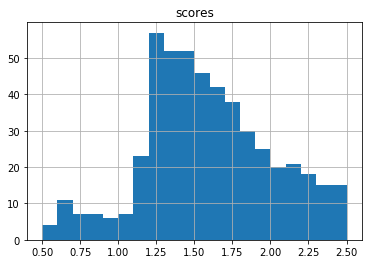

In [824]:
scoring_df[scoring_df['Label'] == True].hist('scores', bins = [0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5])
plt.show()


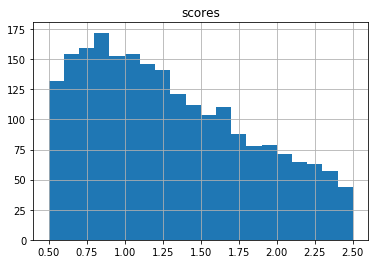

In [825]:
scoring_df[scoring_df['Label'] == False].hist('scores', bins = [0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5])
plt.show()

## Pick the largest score from each call

In [826]:
#hist = scoring_df.groupby(['dial_id'])['scores'].max().reset_index()
dials = set(scoring_df['dial_id'])
best_scores = pd.DataFrame()

for dial in dials:
    df = scoring_df[scoring_df['dial_id'] == dial]
    df = df.nlargest(1, 'scores')
    best_scores = pd.concat([best_scores, df], axis = 0)


    

In [827]:
best_scores.drop_duplicates(subset = ['dial_id'], inplace=True)
len(best_scores)

884

In [828]:
orders[orders['call_id_y'] == "fee90334-f7d3-1235-06b0-0cc47a392728"]

,Label,Unnamed: 0.1.1,abs_time,created,duration_x,event_value,organization_name,position,position_list,time,...,time from start,call_id_y,created_at,prediction,words,event value,dial_id,agreement,order,scores
1,False,113398,2017-08-09 18:33:25.200000+00:00,2017-08-09 18:32:55 UTC,400.782569,first,Zenreach,"(21, 22)","[21, 22]",30.20,...,0.197799,fee90334-f7d3-1235-06b0-0cc47a392728,2017-08-09 18:32:55,[2018-08-01 00:00:00],[noise] yes gotcha [noise] [noise] [noise] [no...,first,fee90334-f7d3-1235-06b0-0cc47a392728,"[2017-08-16 00:00:00, None, None, None, None, ...",6,0.744466
2,False,113400,2017-08-09 18:36:01.600000+00:00,2017-08-09 18:32:55 UTC,400.782569,first,Zenreach,"(390, 391)","[390, 391]",186.60,...,1.222163,fee90334-f7d3-1235-06b0-0cc47a392728,2017-08-09 18:32:55,[2018-08-01 00:00:00],when people are coming and going like if someb...,first,fee90334-f7d3-1235-06b0-0cc47a392728,"[2017-08-16 00:00:00, None, None, None, None, ...",5,1.562163
4,False,113408,2017-08-09 18:36:30.090000+00:00,2017-08-09 18:33:05 UTC,400.782569,tuesday,Zenreach,"(252, 253)","[252, 253]",205.09,...,1.343266,fee90334-f7d3-1235-06b0-0cc47a392728,2017-08-09 18:33:05,[2017-08-15 00:00:00],um-hum [noise] [noise] [noise] [noise] [noise]...,tuesday,fee90334-f7d3-1235-06b0-0cc47a392728,"[2017-08-16 00:00:00, None, None, None, None, ...",4,1.613266
3,False,113402,2017-08-09 18:36:26.710000+00:00,2017-08-09 18:32:55 UTC,400.782569,monday,Zenreach,"(500, 501)","[500, 501]",211.71,...,1.386624,fee90334-f7d3-1235-06b0-0cc47a392728,2017-08-09 18:32:55,[2017-08-14 00:00:00],you would uh have time for potentially a like ...,monday,fee90334-f7d3-1235-06b0-0cc47a392728,"[2017-08-16 00:00:00, None, None, None, None, ...",3,1.959958
5,False,113411,2017-08-09 18:38:30.300000+00:00,2017-08-09 18:33:05 UTC,400.782569,first,Zenreach,"(453, 454)","[453, 454]",325.30,...,2.130598,fee90334-f7d3-1235-06b0-0cc47a392728,2017-08-09 18:33:05,[2018-08-01 00:00:00],kind of take a look and see what it is first u...,first,fee90334-f7d3-1235-06b0-0cc47a392728,"[2017-08-16 00:00:00, None, None, None, None, ...",2,3.250598
0,True,7527,2017-08-09 18:38:40.910000+00:00,2017-08-09 18:32:55 UTC,400.782569,tuesday,Zenreach,"(798, 799)",NaN,345.91,...,2.265586,fee90334-f7d3-1235-06b0-0cc47a392728,2017-08-09 18:32:55,[2017-08-15 00:00:00],to go ahead and do it at ten a.m. on tuesday i...,tuesday,fee90334-f7d3-1235-06b0-0cc47a392728,"[2017-08-16 00:00:00, None, None, None, None, ...",1,3.265586


In [829]:
comparison[comparison['call_id'] == "fee90334-f7d3-1235-06b0-0cc47a392728"]

,call_id,created_at,words_x,prediction,Follow up Time_left,event_value
1,fee90334-f7d3-1235-06b0-0cc47a392728,2017-08-09 18:32:55,to go ahead and do it at ten a.m. on tuesday i...,[2017-08-15 00:00:00],2017-08-15 14:42:30 UTC,tuesday


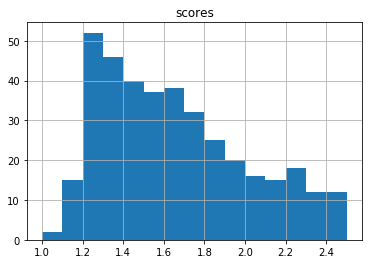

In [847]:
best_scores[best_scores['Label'] == True].hist('scores', bins = [1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5])
plt.show()

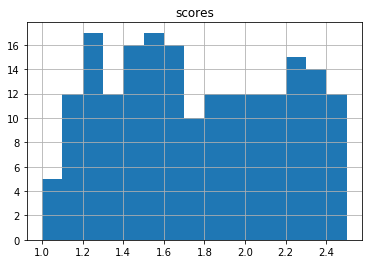

In [848]:
best_scores[best_scores['Label'] == False].hist('scores', bins = [1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5])
plt.show()

## Join on labels, do error analysis

In [830]:
labels = pd.read_csv('/Users/pranavbarot/Desktop/DataSci/new_cnn_data.csv')

In [831]:
comparison = best_scores.merge(labels, how = 'inner', left_on=['call_id_y','event_value'], right_on=['call_id','words'])


In [832]:
comparison = comparison[['call_id','created_at','words_x','prediction','Follow up Time_left','event_value']]

In [833]:
from datetime import datetime
from dateutil import parser

deltas = []
ids = []
words = []
prediction = []
actual = []

for idx, row in enumerate(comparison.itertuples()):
    true = row[-2]
    true = true[0:10]
    utt = row[3]
    pred = row[-3]
    real = row[-2]

    
    ids.append(row[1])
    if (len(pred) >0 and pred != [None]):
        snip = str(pred[0])[0:10]

        deltas.append(parser.parse(snip) - parser.parse(true))
        words.append(utt)
        prediction.append(pred)
        actual.append(real)
        
        

In [834]:
plot = pd.DataFrame(zip(ids, deltas, words, prediction, actual))
days = []
for idx, row in enumerate(plot.itertuples()):
    day = row[2]
    day=str(day)[0:2]
    days.append(int(day))
plot[1] = days
plot.rename(columns = {0:"id",1:"deltas", 2:"words", 3:"prediction",4:"real"}, inplace = True)

In [835]:
len(plot)

642

In [842]:
plot

,id,deltas,words,prediction,real
0,d82d01a2-8c22-11e7-af57-b187703cdd9f,3,right thank you so much appreciate it have a g...,[2017-09-04 00:00:00],2017-09-01 17:52:52 UTC
1,fee90334-f7d3-1235-06b0-0cc47a392728,0,to go ahead and do it at ten a.m. on tuesday i...,[2017-08-15 00:00:00],2017-08-15 14:42:30 UTC
2,65408315-fe38-1235-06b0-0cc47a392728,4,[noise] [noise] [noise] [noise] hey that rush ...,[2017-08-21 00:00:00],2017-08-17 22:48:11 UTC
3,a520093c-e69e-1235-06b0-0cc47a392728,-3,expect i shouldn't you back from you by monday...,[2017-07-25 00:00:00],2017-07-28 21:52:43 UTC
4,5a17cdc1-fee7-1235-06b0-0cc47a392728,-2,i just i'm not going to be in the office satur...,[2017-08-19 00:00:00],2017-08-21 18:09:30 UTC
5,2b5eef89-02bf-1236-06b0-0cc47a392728,6,[noise] [noise] then reach uh i spoke with him...,[2017-08-29 00:00:00],2017-08-23 17:32:57 UTC
6,81d9e157-cb04-1235-06b0-0cc47a392728,0,or remind you and then i'll give you a call mo...,[2017-06-19 00:00:00],2017-06-19 17:03:26 UTC
7,4f36f711-f09d-1235-06b0-0cc47a392728,7,right um yeah well i'll give you a call next m...,[2017-08-07 00:00:00],2017-07-31 14:13:45 UTC
8,573de93a-0399-1236-06b0-0cc47a392728,0,and i'll make sure that you in sam connect on ...,[2017-08-28 00:00:00],2017-08-28 16:03:26 UTC
9,6c085706-d227-1235-06b0-0cc47a392728,0,so that we can just hit the ground running on ...,[2017-06-28 00:00:00],2017-06-28 18:48:00 UTC


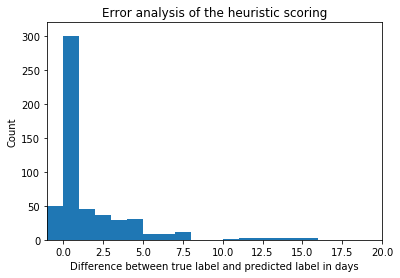

In [837]:
plotting = [i for i in plot['deltas'].tolist()]
import matplotlib.pyplot as plt
plt.hist(plotting,cumulative=False, bins = [-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
plt.title("Error analysis of the heuristic scoring")
plt.xlabel("Difference between true label and predicted label in days")
plt.xlim(-1,20)
plt.ylim(0,320)
plt.ylabel("Count")
plt.show()

In [838]:
plotting = [i for i in plotting if i < 15 and i >=0]
len(plotting)

478

In [839]:
def get_correct(values):
    correct = 0
    for i in values:
        sums = plotting.count(i)
        correct = correct +sums
    return correct

In [849]:
precision = float(get_correct([0,1,-1]))/float(len(plotting))

## Precision of the prediction is

In [850]:
print(precision)

0.721757322176


In [791]:
len(scoring_df['scores'])

5427

In [792]:
1. CNN confidence -->
2. Agreement --> 
3. % of call completed --> 

sample calculation:
    
    0.85 + (2/len(num_events)) + 0.73 = 



SyntaxError: invalid syntax (<ipython-input-792-04649683d645>, line 1)

# 

In [ ]:
%matplotlib inline
events_df['probability'].hist(bins=[0.5,0.6,0.7,0.8,0.9,1])

In [ ]:
events_df[['words','probability']].to_clipboard()

In [ ]:
import numpy as np
x = np.arange(len(events_df))


plt.bar(x,height = events_df['probability'])
plt.show()

In [ ]:
plt.scatter(x, events_df['probability'])
plt.show()

# Save events to disk

In [ ]:
date = datetime.datetime.now().strftime('%Y-%m-%d')
print date

In [ ]:
events_df.sort_index(axis=1, inplace=True)

### Privacy Filter Code

In [ ]:
# Run privacy filter
import privacy_filter
print len(events_df)
events_df = events_df[events_df['callee_words'].apply(lambda x: not privacy_filter.is_pii_al(str(x)))]
print len(events_df)

# Filter events
print len(events_df)
events_df = events_df[events_df['caller_words'].apply(lambda x: not privacy_filter.is_pii_al(str(x)))]
print len(events_df)

In [ ]:
events_df.to_csv('neg_events.csv', index=False)

# Create audio

In [ ]:
moment = parameters['moment']
print moment

In [ ]:
ENDPOINT = 'https://slice-dot-talkiq-echelon.appspot.com'

def download_a_slice(definition):
    r = requests.post('{}/slice'.format(ENDPOINT), json=definition)
    if r.status_code == 200:
        mp3 = r.content
        return mp3
    try:
        msg = r.json()
    except:
        msg = r.text
    raise Exception('Ruh-roh: {} -> {}'.format(
        r.status_code,
        msg
    ))

def save_mp3(mp3, file_name):
    with open(file_name, 'wb') as f:
        f.write(mp3)

In [ ]:
date = datetime.datetime.now().strftime('%Y-%m-%d')
local_folder = os.path.join("audio", moment, date)
if not os.path.exists(local_folder):
    os.makedirs(local_folder)

print local_folder

In [ ]:
# Download merged and spliced mp3s
counter = 0
failed = []
for idx, row in events_df.iterrows():
    counter+=1
    definition = {'call_id': row['call_id'],
                  'call_side':row['side'],
                  'start_time': row['time_start'],
                  'end_time': row['time_end']}
    try:
        mp3 = download_a_slice(definition)
        local_file = os.path.join(local_folder, row['event_id']+".mp3")
        #local_file = os.path.join(local_folder, str(row['call_id'])+"_"+str(row['side'])+"_s_"+str(row['position_start'])+"_e_"+str(row['position_end'])+".mp3")
        save_mp3(mp3, local_file)
    except Exception as e:
        print e
        failed.append(row['call_id'])
        continue
    
    if counter % 10 == 0:
        print "{} of {} merged audio files downloaded".format(counter, len(events_df))

In [ ]:
# drop failed
print failed

# Drop events that failed to download
events_df = events_df[~events_df['call_id'].isin(failed)]

In [ ]:
# Test some files
event = events_df.iloc[1]
local_file = os.path.join(local_folder, event['event_id']+".mp3")
print local_file
print "callee words: {}".format(event['callee_words'])
print "caller words: {}".format(event['caller_words'])
!play "{local_file}"

In [ ]:
events_df.to_csv('temp_events_df.csv', index=False)

# Upload to gcloud


In [ ]:
print date

In [ ]:
# define credentails and file locations
GOOGLE_APPLICATION_CREDENTIALS_PATH = "/opt/service-echelon.json"
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = GOOGLE_APPLICATION_CREDENTIALS_PATH
# Create bucket
GCLOUD_BUCKET = "scale-api-public-6bdf6d9a-6685-11e7-907b-a6006ad3dba0"
GCLOUD_FOLDER = os.path.join("audio_tasks", "classification", moment, date)
print GCLOUD_FOLDER

In [ ]:
client = storage.Client()
bucket = client.get_bucket(GCLOUD_BUCKET)

In [ ]:
gcloud_link = []
counter = 0
failed = []

for idx, row in events_df.iterrows():
    local_file = os.path.join(local_folder, row['event_id']+".mp3")
    blob = bucket.blob(os.path.join(GCLOUD_FOLDER, local_file.split('/')[-1]))
    try:
        blob.upload_from_filename(local_file)
        gcloud_link.append(urllib.unquote(urllib.unquote(blob.public_url)))
    except Exception as e:
        failed.append(row['call_id'])
        print e
        continue
        
    counter+=1
    if counter % 10 == 0:
        print "{} of {} files uploaded".format(counter, len(events_df))

In [ ]:
print failed
# Drop events that failed to upload
events_df = events_df[~events_df['call_id'].isin(failed)]
events_df['gcloud_link'] = gcloud_link

In [ ]:
events_df.to_csv('temp_events_df.csv', index=False)

# Upload events to BQ

In [ ]:
assert set(events_df.columns) == set(['call_id','callee_words','caller_words','created_at',
    'event_id','event_name','gcloud_link','link','model_name',
    'model_version','org','position_end','position_start',
    'probability','processed_at','side','time_end','time_start',
    'uncertainty','words'])

In [ ]:
# Fix column dtypes for BQ
events_df['model_version'] = events_df['model_version'].astype(str)
events_df['time_start'] = events_df['time_start'].astype(float)
events_df['time_end'] = events_df['time_end'].astype(float)
events_df['probability'] = events_df['probability'].astype(float)
events_df['uncertainty'] = events_df['uncertainty'].astype(float)
events_df['created_at'] = pd.to_datetime(events_df['created_at'])
events_df['processed_at'] = pd.to_datetime(events_df['processed_at'])

In [ ]:
len(events_df)

In [ ]:
events_df.to_gbq("hits.audio_classification_events_2", project_id='talkiq-data', if_exists='append', private_key='/opt/service-data.json')

In [ ]:
local_folder = os.path.join("data","events")
local_file = os.path.join(local_folder,"{0}_events_{1}.csv".format(moment, date.split()[0]))
print local_folder
print local_file

In [ ]:
if not os.path.exists(local_folder):
    os.makedirs(local_folder)

# Save to csv formats
events_df.to_csv(local_file, index=False, date_format='%Y-%m-%d %H:%M:%S UTC')